## Evaluation Metrics for Classification

Dataset: https://www.kaggle.com/blastchar/telco-customer-churn

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

Load the necesary modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

* Load the Dataset
* Replace the _ from string values
* Identify the categorical columns
* Convert the totalcharges to numerical

In [2]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

* Split the data for train and test
* drop the target column in train and test set

In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

* Classified the data set

In [4]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

* Create DictVectorizer
* Train the converted dict values
* Fit the model into LogisticRegression

In [5]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

Predict the value from generated model

In [6]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

# Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines


# What is accuracy?
Accuracy tells the how many correct predictions were made

Accuracy can be calculated using below formula

$Accuracy = \cfrac{TP + TN }{TP + TN + FP + FN}$

In [7]:
len(y_val)

1409

In [8]:
(y_val == churn_decision).sum()

1132

# What are thresholds?
Recall that in our model, we made it such that if y_pred >= 0.5, it would be counted as 1. However, that probability can be adjusted such that we can make stricter predictions or more lenient predictions.

For example, instead of 0.5, we can make it such that anything from 0.3 onwards would be counted as 1, or anything from 0.74 would be counted as 1.

In [9]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(score)

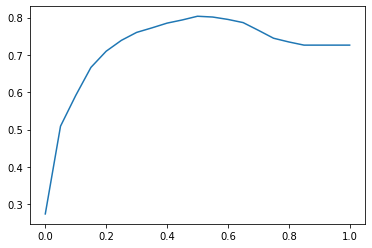

In [12]:
plt.plot(thresholds, scores)





Afterthoughts of accuracy:

Accuracy does not tell us how good a model is if there is a class imbalance. Only with balanced data (such as data that is 50/50, or a bit more varied than that) would accuracy be a good metric to use. We have to look at other evaluation metrics

In [13]:
from collections import Counter

In [14]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

# Confusion table


|   | Negative  | Positive   |
| ------------ | ------------ | ------------ |
|  Negative | True Negative (TN)  | False Positive (FP)  |
|  Positive | False Negative (FN)  |  True Positive (TP) |


Different types of errors and correct decisions
* Arranging them in a table
* Basics of a confusion table/matrix (as some people would call it):

There will be 2 possible scenarios when there is a prediction of no churn:

* The customer indeed didn't churn - also known as a true negative
* The customer actually churned - also knows as a false negative

The same thing will happen when there is a prediction of churn:

* The customer indeed churned - also known as a true positive
* The customer actually didn't churn - also known as a false positive
These four scenarios form a confusion table/matrix.

In [15]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [16]:
pred_positive = (y_pred >= 0.5)
pred_negative = (y_pred < 0.5)

In [17]:
tn = (pred_negative & actual_negative).sum()
tp = (pred_positive & actual_positive).sum()

In [18]:
fn = (pred_negative & actual_positive).sum()
fp = (pred_positive & actual_negative).sum()

In [19]:
confusion_matrix = np.array([[tn, fp],
                           [fn,tp]])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [20]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

# Precision, Recall, TPR and FPR

$P(recision) = \cfrac{TP}{TP + FP}$

$R(ecall) = \cfrac{TP}{TP + FN}$

$TPR = \cfrac{TP}{TP + FP}$

$FPR = \cfrac{FP}{FP + TN}$

In [21]:
p = tp / (tp+fp)
p

0.6752411575562701

In [22]:
r = tp / (tp + fn)
r

0.5440414507772021

In [23]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [24]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

# ROC curve

[![](https://ars.els-cdn.com/content/image/3-s2.0-B9780124115118000062-f06-03-9780124115118.jpg)](https://ars.els-cdn.com/content/image/3-s2.0-B9780124115118000062-f06-03-9780124115118.jpg)

A receiver operating characteristic (ROC) curve is taken from a coverage curve by normalizing the axes to [0, 1]. But generally, coverage curves can be rectangular whereas ROC curves always occupy the unit square. Moreover, while in a coverage plot the area under the coverage curve gives the absolute number of correctly ranked pairs; in an ROC plot the area under the ROC curve (AUC) is the ranking accuracy (Flach, 2012). One tool that enhances the classifier performance assessment/evaluation in multiple points of operation, comparison, and selection is the ROC analysis. ROC was the methodology used for detecting radar signals during World War II and turned out to be profitable for the classifier evaluation

[source: https://www.sciencedirect.com/topics/computer-science/true-positive-rate]

In [25]:
thresholds  = np.linspace(0, 1, 101)
scores = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    pred_positive = (y_pred >= t)
    pred_negative = (y_pred < t)
    
    tp = (pred_positive & actual_positive).sum()
    tn = (pred_negative & actual_negative).sum()
    fp = (pred_positive & actual_negative).sum()
    fn = (pred_negative & actual_positive).sum()
    scores.append((t, tp,tn,fp,fn))

In [26]:
scores[:3]

[(0.0, 386, 0, 1023, 0), (0.01, 385, 110, 913, 1), (0.02, 384, 193, 830, 2)]

In [27]:
columns = ['threshold','tp','tn','fp','fn']
df_scores = pd.DataFrame(scores, columns=columns)

In [28]:
df_scores

,threshold,tp,tn,fp,fn
0,0.00,386,0,1023,0
1,0.01,385,110,913,1
2,0.02,384,193,830,2
3,0.03,383,257,766,3
4,0.04,381,308,715,5
...,...,...,...,...,...
96,0.96,0,1023,0,386
97,0.97,0,1023,0,386
98,0.98,0,1023,0,386
99,0.99,0,1023,0,386


In [29]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [30]:
df_scores[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,366,467,556,20,0.948187,0.543500
20,0.2,333,667,356,53,0.862694,0.347996
30,0.3,284,787,236,102,0.735751,0.230694
40,0.4,249,857,166,137,0.645078,0.162268
50,0.5,210,922,101,176,0.544041,0.098729
60,0.6,150,970,53,236,0.388601,0.051808
70,0.7,76,1003,20,310,0.196891,0.019550
80,0.8,13,1022,1,373,0.033679,0.000978
90,0.9,0,1023,0,386,0.000000,0.000000


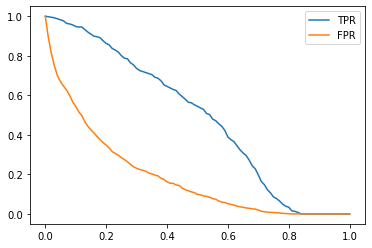

In [31]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

# Random Model

Predict the value based on randomly selected values

In [32]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [33]:
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [34]:
def tpr_fpr_df(y_val, y_pred):
    thresholds  = np.linspace(0, 1, 101)
    scores = []
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        pred_positive = (y_pred >= t)
        pred_negative = (y_pred < t)

        tp = (pred_positive & actual_positive).sum()
        tn = (pred_negative & actual_negative).sum()
        fp = (pred_positive & actual_negative).sum()
        fn = (pred_negative & actual_positive).sum()
        scores.append((t, tp,tn,fp,fn))
    columns = ['threshold','tp','tn','fp','fn']
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    return df_scores

In [35]:
df_rand = tpr_fpr_df(y_val, y_rand)

In [36]:
df_rand[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,347,100,923,39,0.898964,0.902248
20,0.2,307,201,822,79,0.795337,0.803519
30,0.3,276,299,724,110,0.715026,0.707722
40,0.4,237,399,624,149,0.613990,0.609971
50,0.5,202,505,518,184,0.523316,0.506354
60,0.6,161,614,409,225,0.417098,0.399804
70,0.7,121,721,302,265,0.313472,0.295210
80,0.8,78,817,206,308,0.202073,0.201369
90,0.9,40,922,101,346,0.103627,0.098729


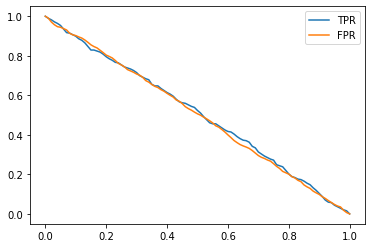

In [37]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

# Ideal Model

Use the actual values from the training set and make the predictions

In [38]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

In [39]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [40]:
y_ideal_pred = np.linspace(0, 1, len(y_val))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

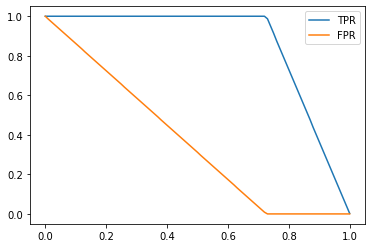

In [41]:
df_ideal = tpr_fpr_df(y_ideal, y_ideal_pred)
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

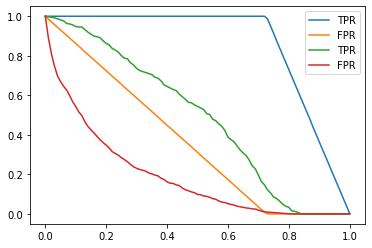

In [42]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

# ROC curve and AUC using sklearn libraries

In [43]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

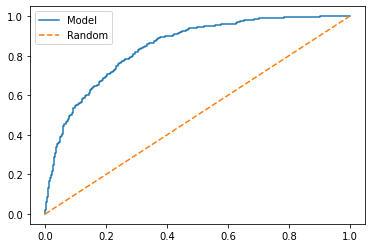

In [44]:
plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.legend()

In [45]:
y_val

array([0, 0, 0, ..., 0, 1, 1])

In [46]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]
pos

array([0.54304201, 0.58226734, 0.46169532, 0.73942733, 0.06580641,
       0.69174219, 0.24736811, 0.69653769, 0.21208494, 0.66509702,
       0.4734741 , 0.34864541, 0.15046357, 0.61756132, 0.76471688,
       0.14248396, 0.43289524, 0.27301047, 0.06885686, 0.19234033,
       0.67062685, 0.41597207, 0.66202254, 0.58316459, 0.52439051,
       0.43307551, 0.46856629, 0.35114877, 0.56774582, 0.32177406,
       0.63521787, 0.74369371, 0.73843161, 0.6089276 , 0.70873063,
       0.76477934, 0.10729572, 0.18071687, 0.54203627, 0.57942937,
       0.43655819, 0.44059657, 0.75706846, 0.38574479, 0.69438187,
       0.41765369, 0.75786386, 0.30225735, 0.53389686, 0.58068373,
       0.15407375, 0.52946122, 0.78578055, 0.43643641, 0.67325446,
       0.77440233, 0.0126373 , 0.35107602, 0.79769441, 0.58466216,
       0.67391352, 0.24822175, 0.34497523, 0.70163142, 0.20961148,
       0.6859309 , 0.63630383, 0.29105961, 0.66049677, 0.30802139,
       0.50166741, 0.27182148, 0.39709269, 0.41039806, 0.49930

In [47]:
import random

n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos)-1)
    neg_ind = random.randint(0, len(neg)-1)
    if pos[pos_ind] > neg[neg_ind]:
        success += 1
success / n

0.84447

In [48]:
n = 50000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [49]:
(pos[pos_ind] > neg[neg_ind]).mean()

0.84486

In [50]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

In [51]:
dv, model =  train(df_train, y_train, C=0.001)

In [52]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [53]:
y_pred = predict(df_val, dv, model)
y_pred

array([0.02155921, 0.33135098, 0.33602112, ..., 0.26705435, 0.71907523,
       0.71942517])